In [1]:
import matplotlib.pyplot as plt
from lib.models.face_cropper import FaceCropper
from lib.raw_datasets import segmentation

In [2]:
fc = FaceCropper()

def plot_preprocessing(im):
    plt.figure(figsize=(16, 8))

    plt.suptitle('Preprocessing results', fontsize=18)

    plt.subplot(141)
    plt.title('Original image')
    plt.imshow(im)
    plt.axis('off')

    plt.subplot(242)
    plt.title('Cropped face')
    plt.imshow(
        fc.apply(im),
    )
    plt.axis('off')

    plt.subplot(246)
    plt.title('Scaled')
    plt.imshow(
        segmentation.preprocess_image(im),
    )
    plt.axis('off')

    plt.subplot(247)
    plt.title('Mask')
    plt.imshow(
        segmentation.preprocess_image(im),
    )
    plt.axis('off')

    plt.subplot(248)
    plt.title('Result')
    plt.imshow(
        segmentation.preprocess_image(im),
    )
    plt.axis('off')

    plt.show()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


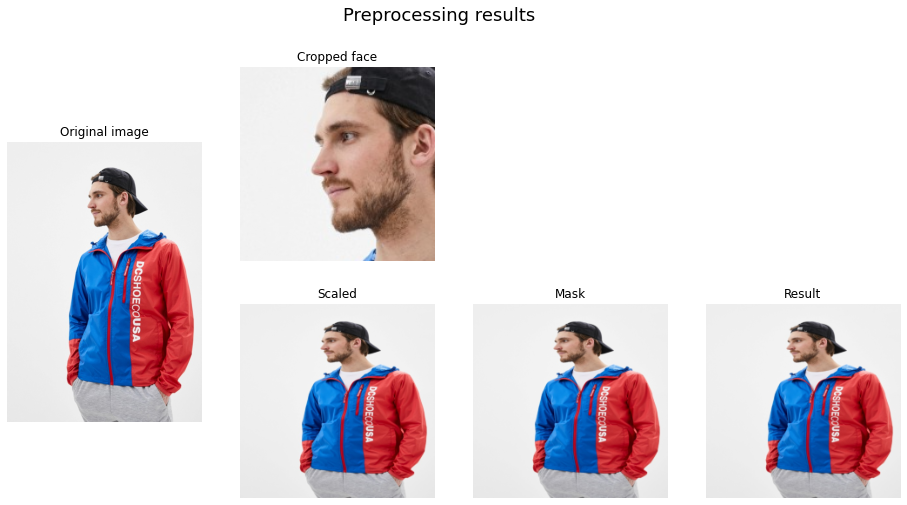

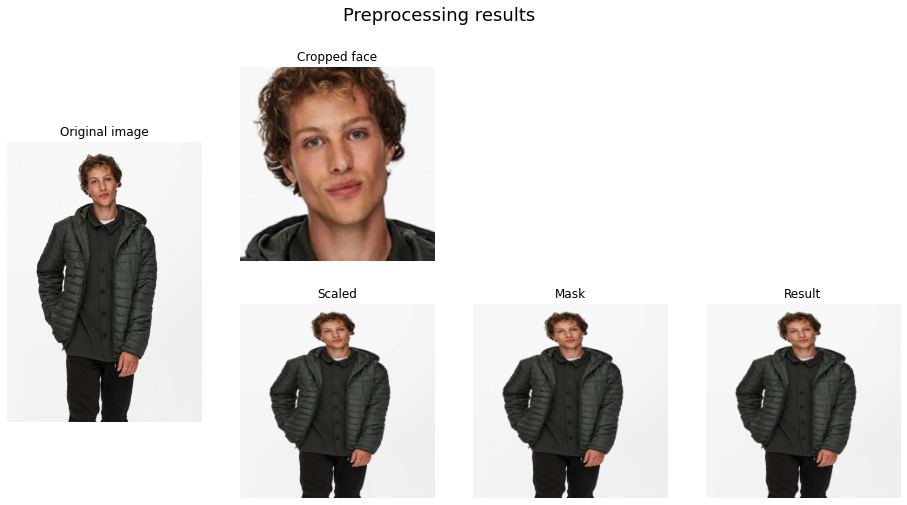

In [3]:
for fname in [
    'data/preprocessing/original1.jpg',
    'data/preprocessing/original2.jpg',
]:
    im = plt.imread(fname)
    plot_preprocessing(im)

In [4]:
import torch
from lib.torch_models.unet import UNET

unet_checkpoint = torch.load('../data/checkpoints/unet.ckpt')


unet = UNET(num_classes=10)
unet.load_state_dict({
    '.'.join(k.split('.')[1:]): v for k, v in unet_checkpoint['state_dict'].items()
})

<All keys matched successfully>

(1300, 600, 3)


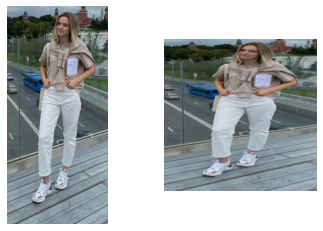

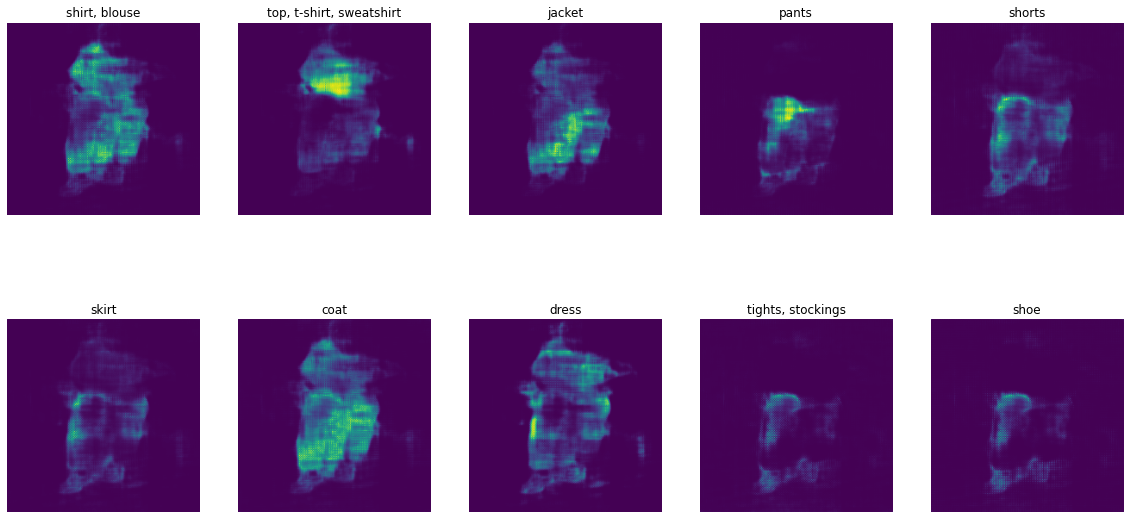

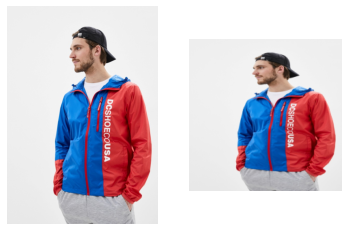

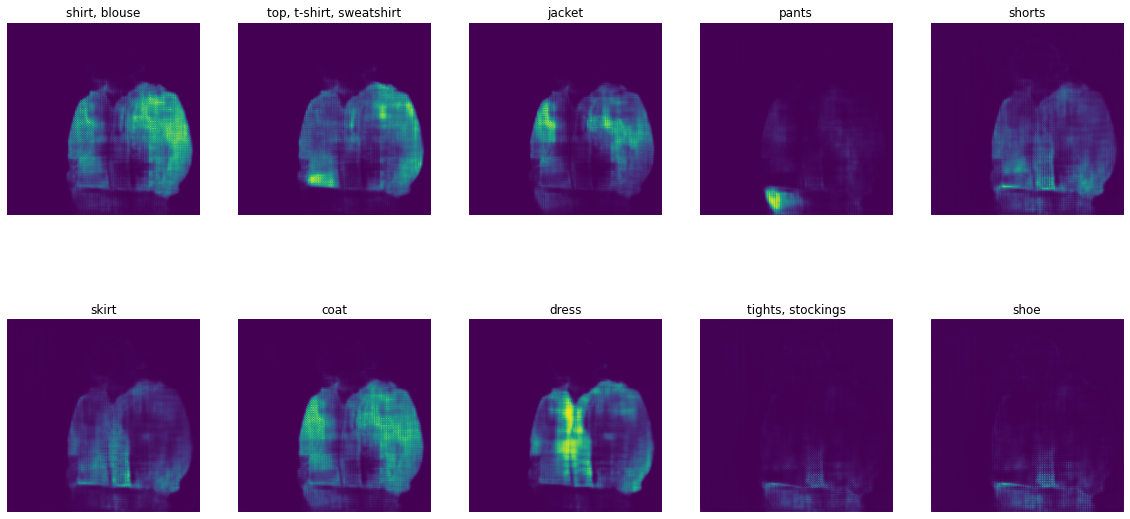

In [5]:
names = [
    'shirt, blouse',
    'top, t-shirt, sweatshirt',
    'jacket',
    'pants',
    'shorts',
    'skirt',
    'coat',
    'dress',
    'tights, stockings',
    'shoe',
]

for fname in [
    '../../polya.jpg',
    'data/preprocessing/original1.jpg',
    # 'data/preprocessing/original2.jpg',
]:
    im = plt.imread(fname)
    if fname == '../../polya.jpg':
        im = im[700:2000, 600:1200]
        print(im.shape)
    plt.subplot(121)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(segmentation.preprocess_image(im))
    plt.axis('off')
    plt.show()
    preprocessed = segmentation.preprocess_image(im).transpose(2, 0, 1)
    t = torch.tensor(preprocessed).float().unsqueeze(0)
    res = unet.forward(t)[0].detach().numpy()
    plt.figure(figsize=(20, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.title(names[i])
        plt.imshow(res[i])
        plt.axis('off')
        
    plt.show()

In [73]:
res.shape

(10, 224, 224)

In [30]:
from skimage.filters import gaussian

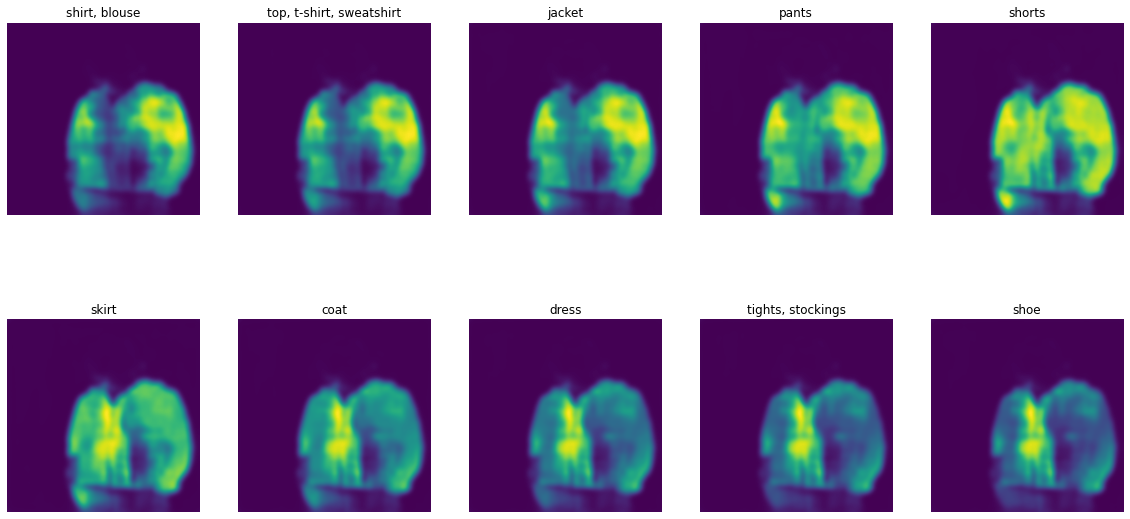

In [40]:
smoothed = gaussian(res, 3.)

plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(names[i])
    plt.imshow(smoothed[i])
    plt.axis('off')

In [75]:
(np.indices((224, 224)) / 223)[:, 223, 4]

array([1.        , 0.01793722])

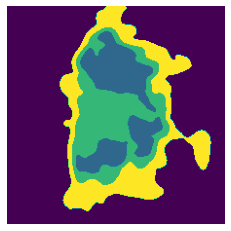

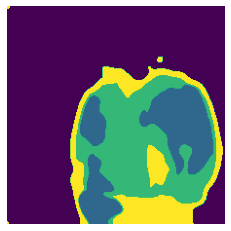

In [83]:
for fname in [
    '../../polya.jpg',
    'data/preprocessing/original1.jpg',
    # 'data/preprocessing/original2.jpg',
]:
    im = plt.imread(fname)
    if fname == '../../polya.jpg':
        im = im[700:2000, 600:1200]

    preprocessed = segmentation.preprocess_image(im).transpose(2, 0, 1)
    t = torch.tensor(preprocessed).float().unsqueeze(0)
    res = unet.forward(t)[0].detach().numpy()

    smoothed = gaussian(res, 3.)

    from sklearn.mixture import GaussianMixture
    import numpy as np

#     X = np.concatenate(
#         [smoothed, 0.0 * np.indices((224, 224))], axis=0
#     ).reshape(12, 224**2).T
    
    X = smoothed.reshape(10, 224**2).T

    gm = GaussianMixture(n_components=4, random_state=0).fit(X[:100000])
    labels = gm.predict(X)

    cl = labels.reshape(224, 224)

    plt.imshow(cl / 10)
    plt.axis('off')
    plt.show()